In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import xrft
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
import autolib as al
from dask.distributed import Client
# client = Client(n_workers=28)
# client = Client()
# client

# Remake schematic of topo - zonal - merid waves
### 1. Load a single 3D experiment.
### 2. Pick layer for zonal, layer for merid. 
### 3. Filter with simple anomaly. Plot interfacial heights as surface plots

In [2]:
data = xr.open_dataset("/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-1/archive/output001/e_10min.nc",chunks = ({"xh":50,"yh":50})).sel(yh = slice(-1600,-1400)).isel(time = 115).e

zon_anom = (data - data.mean("xh")).isel(zi = -2).sel(xh = slice(-200,200))
merid = data.isel(zi = 1).sel(xh = slice(-200,200)) + 800
topog = data.isel(zi = -1).sel(xh = slice(-200,200))

merid = (merid * 0) + merid.mean("xh")

# topog.plot()
# plt.figure()
# zon_anom.plot()
# plt.figure()
# merid.plot()
def normalise(x):
    return (x - x.min()) / (x.max() - x.min())

def interp(z,xfac = 10,yfac = 10):

    xnew = np.linspace(z.xh[0],z.xh[-1],round(z.xh.shape[0]*xfac))
    ynew = np.linspace(z.yh[0],z.yh[-1],round(z.yh.shape[0]*yfac))
    znew = z.interp(xh = xnew,yh = ynew)
    return znew

Z_zonal = normalise(zon_anom) * 2
Z_merid = -1 * normalise(merid) + 4.5
Z_topog = normalise(topog) - 2

# # Interpolate Z variables onto higher resolution grids using scipy
#Flip merid for aesthetic purposes

Z_topog = interp(Z_topog,xfac = 10,yfac = 0.05).persist()
# Z_zonal = interp(Z_zonal,xfac = 5,yfac = 5).persist()
# Z_merid = interp(Z_merid,xfac = 0.01,yfac = 10).persist()

# Lower Res for fast plotting
# Z_topog = interp(Z_topog,xfac = 0.5,yfac = 0.05).persist()
Z_zonal = interp(Z_zonal,xfac = 0.5,yfac = 0.5).persist()
Z_merid = interp(Z_merid,xfac = 0.1,yfac = 0.5).persist()


Text(0.5, 0.92, '')

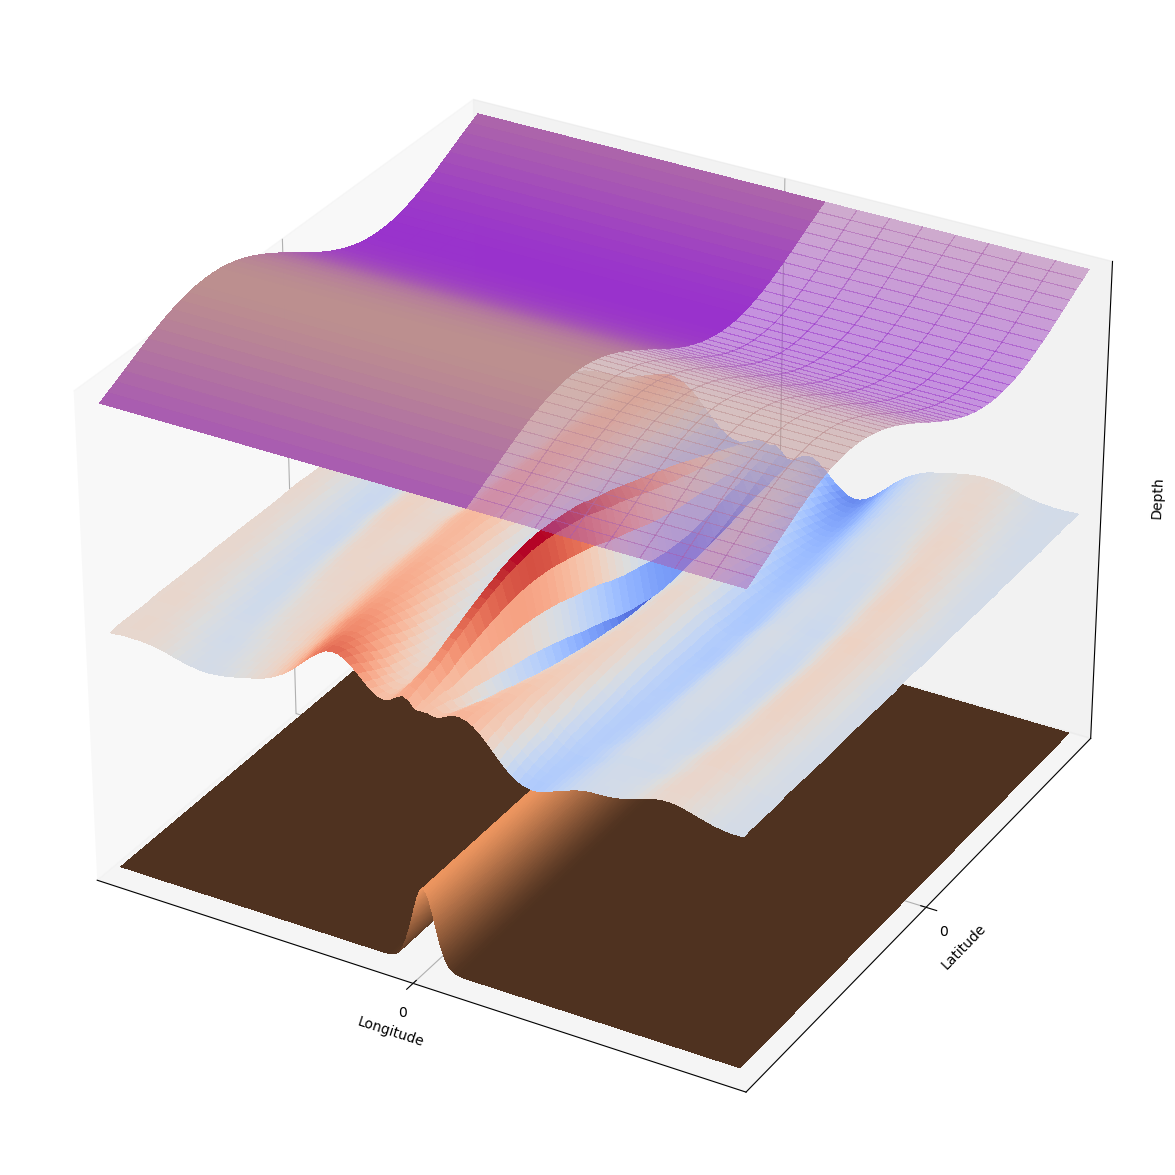

In [ ]:
%matplotlib inline
from matplotlib import cm
import seaborn as sns
from scipy import interpolate
import matplotlib
matplotlib.pyplot.close()

cmap_zonal = sns.color_palette("coolwarm", as_cmap=True)
cmap_topog = sns.color_palette("copper", as_cmap=True)
cmap_merid = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkorchid","rosybrown"])

from matplotlib.colors import LightSource
fig, ax = plt.subplots(figsize = (15,15),subplot_kw={"projection": "3d"})




ls = LightSource(100, 90)
# rgb_zonal = ls.shade(Z_zonal.values, cmap=cmap_zonal, blend_mode='soft')
# rgb_topog = ls.shade(Z_topog.values, cmap=cm.copper, vmin = -2.5 ,vmax = Z_topog.max() * 0.5 ,blend_mode='soft')
# plt.axes("off")


Z_zonal.plot.surface(ax = ax,cmap = cmap_zonal,antialiased=False,cstride = 1,rstride = 1,add_colorbar = False,alpha = 1)
Z_topog.plot.surface(ax = ax,vmin = -2.5,vmax= -0.5,cmap = cmap_topog,antialiased=False,cstride = 1,rstride = 1,add_colorbar = False,alpha = 1)
diff = Z_merid.xh.shape[0] // 2
Z_merid.isel(xh = slice(0,diff + 2)).plot.surface(ax = ax,vmin = 3.5,vmax= 4.5,cmap = cmap_merid,antialiased=False,cstride = 1,rstride = 1,add_colorbar = False,alpha = 0.99)
Z_merid.isel(xh = slice(0,None)).plot.surface(ax = ax,vmin = 3.5,vmax= 4.5,cmap = cmap_merid,antialiased=False,cstride = 1,rstride = 1,add_colorbar = False,alpha = 0.5)
# Z_merid.sel(xh = slice(None,0)).plot.surface(ax = ax,vmin = 2,vmax= 3,cmap = cmap_merid,antialiased=False,cstride = 1,rstride = 1,add_colorbar = False,alpha = 1)


ax.set(xticks=[0],
       yticks=[-1500],
       xlabel="Longitude",
       ylabel="Latitude",
       zlabel="Depth",
       zticks=[],
       xticklabels=[0],
       yticklabels=[0],
       zticklabels=[],
       zlim = [-2,4],
       xlim = [-200,200],
       ylim = [-1600,-1400],)
ax.set_title("")


## Make Hovmöller and spectral plot

In [2]:
path = "june_height_ridge_5layer/june_height_ridge_5layer_height-450"

def horizontal_eslice(path,dim = "xh",var = "e",vcoord = "zi"):
    eslice = xr.open_mfdataset(
        f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{path}/archive/output00*/{var}_10min.nc",chunks = {vcoord:1,dim:500},decode_times = False,parallel=True).isel({"yh" : 250,"time" : slice(0,4152//2)})


    eslice = eslice[var].assign_coords({"time":("time",eslice.time.values * 60),
                            dim:(dim,eslice[dim].values * 1000)
        })

    eanom = (eslice - eslice.mean(dim)).load()
    eslice.close()
    eanom_flipped = xr.DataArray(
        data = eanom[::-1,:,:],
        coords = [600 - eanom.time[::-1],eanom[vcoord],eanom[dim]],
        dims = ["time",vcoord,dim]
    )

    extended = xr.concat([eanom_flipped,eanom],dim = "time")

    ###  COMBINE INTO ONE FUNCTIon
    strat = 1
    if "strat" in path:
        strat = float(path.split("-")[-1])

    e = extended.chunk({vcoord:1})
    
    spectrum = xrft.power_spectrum(e,dim=["time",dim],true_phase = True,true_amplitude = True)

    ## Commentted out include spectrum in saved files
    out = xr.Dataset(
        {"spectrum":spectrum.sel({"freq_time" : slice(0,None),f"freq_{dim}" : slice(0,None)}),"slice":eslice}
    )

    return out

data = horizontal_eslice(path,dim = "xh",var = "e",vcoord = "zi")

data["slice"].to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/newhovmoller_for_figure.nc")
data["spectrum"].to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/newspectrum_for_figure.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 190.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [2]:
spectrum = xr.open_dataarray("/g/data/v45/ab8992/bottom_iwbs/newspectrum_for_figure.nc").isel(zi = 3).persist()
eslice = xr.open_dataarray("/g/data/v45/ab8992/bottom_iwbs/hovmoller_for_figure.nc").isel(zi = 3).persist()

def omega(k,f,N,n,H,l = 0):
    f = np.full(k.shape,f)
    N = np.full(k.shape,N)
    n = np.full(k.shape,n)
    H = np.full(k.shape,H)
    l = np.full(k.shape,l)
    K2 = k**2 + l**2
    
    m = np.pi * n / H
    num = f**2 * m**2 + K2 * N ** 2
    den = K2 + m ** 2
    return np.sqrt(num / den)


def vmodes(k,n):
    k = k
    f = 0.0001 / (np.pi * 2)
    N = np.sqrt((2 * 9.8) / (3275 * 1027))  # N in s^-1
    # N = np.sqrt((2 * 9.8) / (4000 * 1027))  # N in s^-1
    print(f / N)
    m = np.pi * n / 4000
    K2 = 2 * k**2
    num = f**2 * m**2 + K2 * N ** 2
    den = m ** 2
    return np.sqrt(num / den)

# k = spectrum.freq_xh.values
# n = 1
# fig,ax = plt.subplots(1,figsize = (10,10))
# plt.plot(k,vmodes(k,n),color = "red")
# plt.plot(k,vmodes(k,2),color = "red")
# plt.plot(k,vmodes(k,3),color = "red")
# np.log(spectrum.sel(freq_xh = slice(0,6e-5),freq_time = slice(0,0.8e-4))).plot(cmap = cmap1,vmin = 2,vmax = 15,add_colorbar = False, ax = ax)


0.006592998393590467
0.006592998393590467
0.006592998393590467


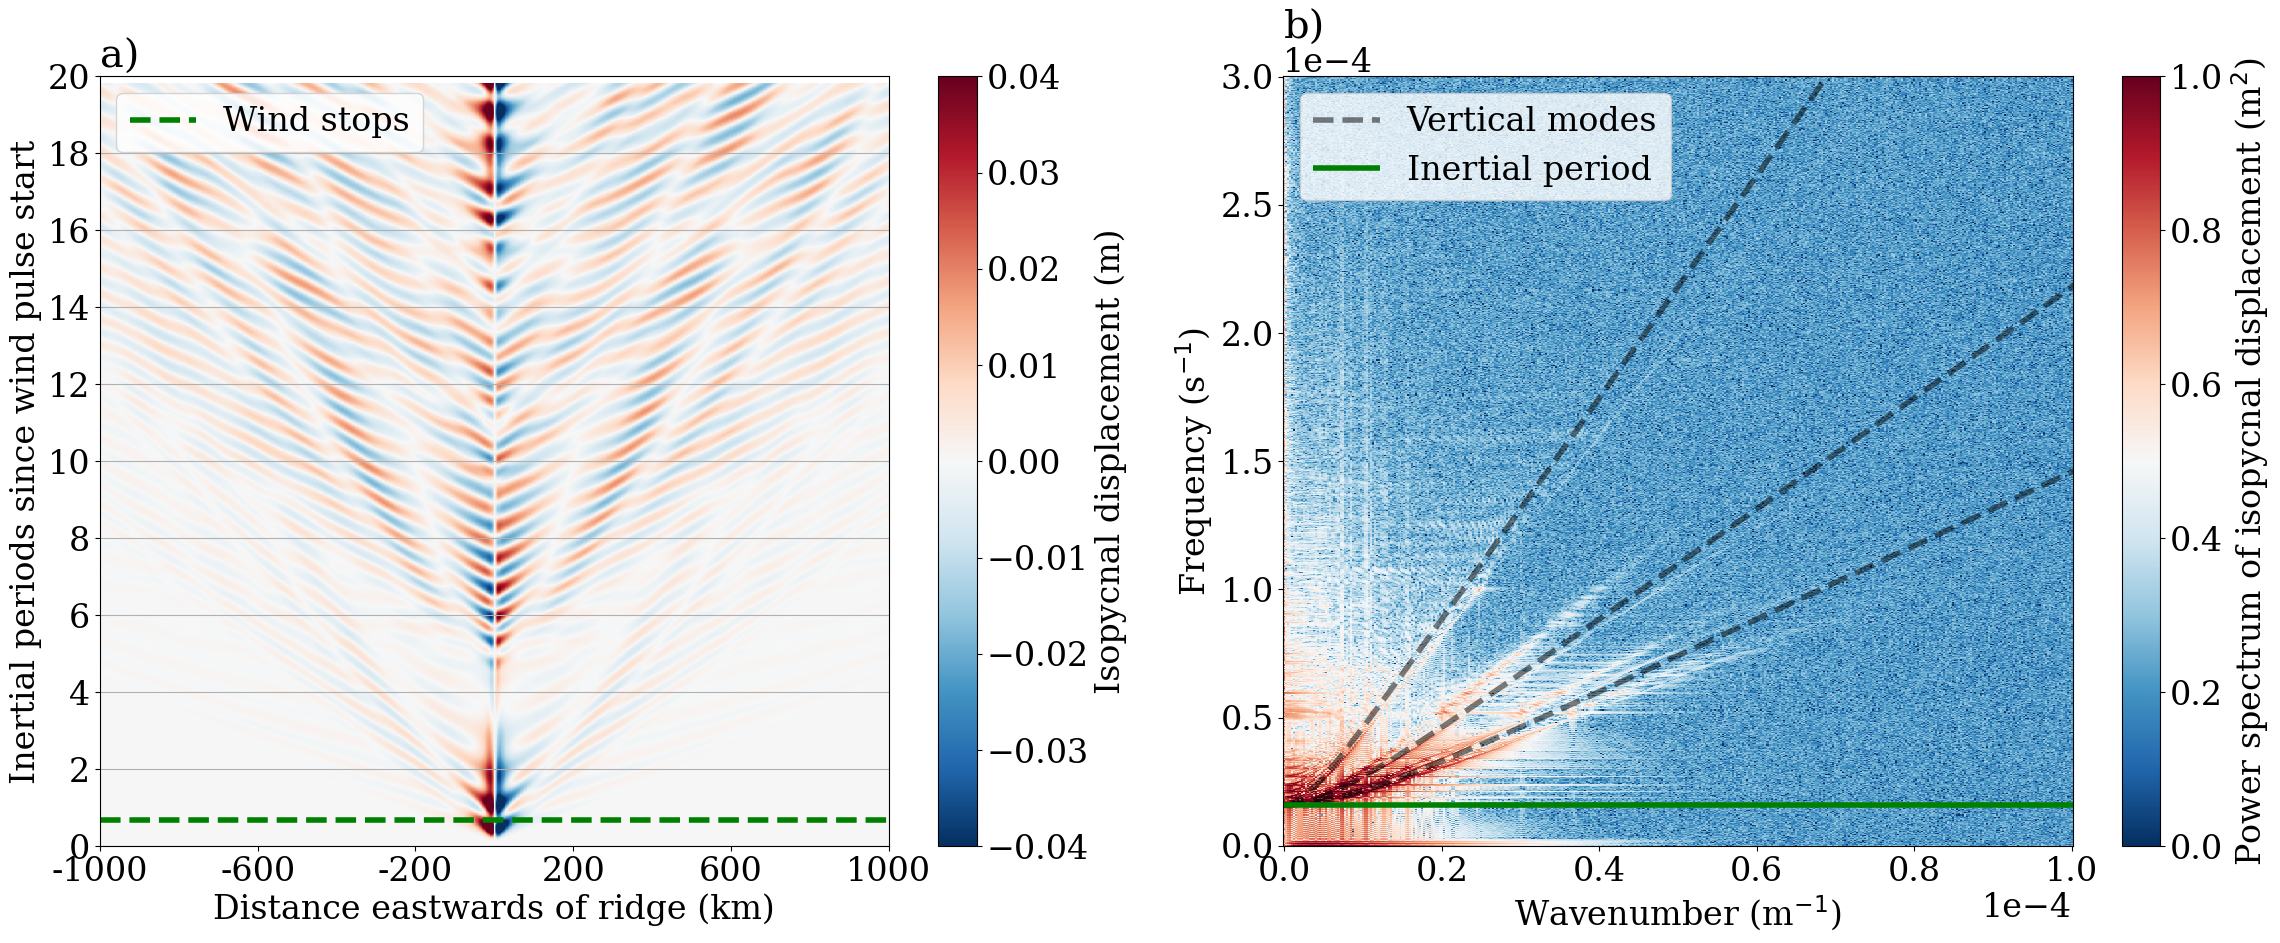

In [6]:
fig,ax = plt.subplots(1,2,figsize = (28,10))
cmap0 = matplotlib.cm.RdBu_r
cmap1 = sns.color_palette("rocket_r", as_cmap=True)
cmap1 = sns.cubehelix_palette(start=.75, rot=-1, as_cmap=True,light = 1)
cmap1 = "RdBu_r"
fp = (2 * np.pi / 0.0001) 
fp_hours = fp * 3600
# plot without colorbar 

vmin_s = -20
vmax_s = 17
vmin_s = -10
vmax_s = None
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 24}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
lw = 4

freq_xhlim = 1e-4
freq_timelim = 3e-4
xmin = -1000000
xmax = 1000000

np.log(spectrum.sel(freq_xh = slice(0,freq_xhlim),freq_time = slice(0,freq_timelim))).plot(cmap = cmap1,vmin = vmin_s,vmax = vmax_s,ax = ax[1],add_colorbar = False)



ax[1].plot(spectrum.freq_xh.values,vmodes(spectrum.freq_xh.values,1),color = "black",lw = lw,linestyle = "--",alpha = 0.5,label = "Vertical modes")
for i in range(2,4):
    ax[1].plot(spectrum.freq_xh.values,vmodes(spectrum.freq_xh.values,i),color = "black",lw = lw,linestyle = "--",alpha = 0.5)
(eslice - eslice.isel(time = 0)).sel(xh = slice(xmin,xmax)).plot(ax = ax[0],vmin = -0.04,vmax = 0.04,cmap = "RdBu_r",add_colorbar = False)
ax[1].hlines(0.0001 / (np.pi * 2),0,0.00014,color = "green",lw = lw,linestyle = "-",label = "Inertial period")
times = np.array([0,24,48,72,96])
times = np.linspace(0,20,11)
lons = np.linspace(-1000000,1000000,6)

ax[0].set_xlabel("Distance eastwards of ridge (km)")
ax[0].set_ylabel("Inertial periods since wind pulse start")
ax[0].set_title("")
ax[0].set_yticks(times * fp)
ax[0].set_yticklabels((times).astype(int))
ax[0].set_ylim((-1,None))
ax[0].grid(axis = "y")
ax[0].set_xticks(lons)
ax[0].set_xticklabels((lons / 1000).astype(int))
ax[0].hlines(12 * 3600,-1000000,1000000,color = "green",lw = lw,linestyle = "--",label = "Wind stops")
## Colorbar 0
# set location of legend to lower left
ax[0].set_title("a)",loc = "left")
ax[0].legend(loc = "upper left")
ax[1].set_title("b)",loc = "left")

norm0 = matplotlib.colors.Normalize(vmin=-0.04, vmax=0.04)
norm1 = matplotlib.colors.Normalize(vmin=vmin_s, vmax=vmax_s)

plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap0),ax = ax[0],label = f"Isopycnal displacement (m)",orientation = "vertical")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm1, cmap=cmap1),ax = ax[1],label = f"Power spectrum of isopycnal displacement (m$^2$)",orientation = "vertical")
ax[1].legend()
ax[1].set_xlabel(r"Wavenumber (m$^{-1}$)")
ax[1].set_ylabel(r"Frequency (s$^{-1}$)")
ax[1].set_title("")
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(-5,-4))

## Power spectrum : Try velocity instead

In [8]:
data_e = xr.open_mfdataset("/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-1/archive/output00*/e_10min.nc",chunks = {"zi":1}).isel(time = slice(0,500)).sel(xh = slice(-400,400),yh = slice(-1502,-1498)).e
data_u = xr.open_mfdataset("/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-1/archive/output00*/u_10min.nc",chunks = {"zl":1}).isel(time = slice(0,500)).sel(yh = slice(-1502,-1498)).u.interp(xq = data_e.xh).drop("xq")

data_u = (data_u - data_u.mean("xh")).sel(xh = slice(-400,400))

data_e = data_e.mean("yh").persist()
data_u = data_u.mean("yh").persist()

# Four frames of movie

here
here
here
here


/jobfs/95596328.gadi-pbs/ipykernel_2598366/1554055556.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([4000,3000,2000,1000,0])


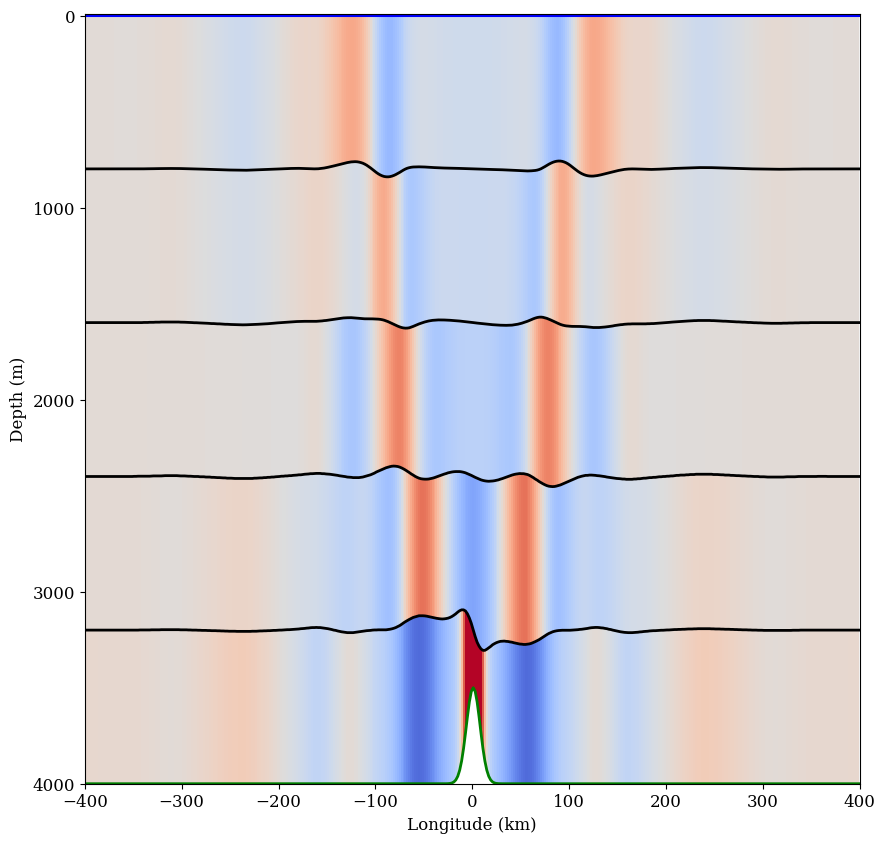

In [ ]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
tt = 150


fig,ax = plt.subplots(1,figsize = (10,10))

vmax = data_u.isel(time = tt).max().values * 0.1
vmax = 0.0001
vmin = -1 * vmax

scaling = 3000 # Scale the anomaly in interface height

gs = GridSpec(5, 12, figure=fig)
axes = []

## plot each layer
# ax = fig.add_subplot(gs[:,:])

x = data_u.xh
mean_depths = data_e.isel(time = 0)
base = mean_depths.isel(zi = 0)
deviation = (data_e.isel(time = tt).isel(zi = 0) - mean_depths[0,tt])
layer = base + deviation * scaling


layer.plot(ax = ax,color = "blue",linewidth = 2)
# for i in range(data_e.zi.shape[0] - 1):
for i in range(0,4):
    print("here")
    prev_layer = layer
    
    ## Plot this layer 
    base = mean_depths.isel(zi = i+1)
    deviation = (data_e.isel(time = tt).isel(zi = i+1) - mean_depths.isel(zi = i+1))
    layer = base + deviation * scaling
    layer.plot(ax = ax,color = "black",linewidth = 2)


    # Create patch for the clipping of velocity field to fill space between layers. See https://matplotlib.org/stable/tutorials/advanced/path_tutorial.html
    
    verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer)], 1)]) ## creates vertices 
    path = Path(verts)
    patch = PathPatch(path, lw = 2,transform=ax.transData) ## patch to clip the velocity field

    # Plot velocity field and apply patch as clip path
    velfield = data_u.isel(time = tt,zl = i).expand_dims({"vert":2},axis = 1)
    extent=[x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],prev_layer.min().values.reshape(1)[0],layer.max().values.reshape(1)[0]]
    X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],x.shape[0]),np.linspace(prev_layer.min().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
    im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
    im.set_clip_path(patch)



## Handle bottom layer case
prev_layer = layer
layer = data_e.isel(time = 0,zi = -1)

layer.plot(ax = ax,color = "green",linewidth = 2)

verts = np.vstack([np.stack([x, layer], 1), np.stack([np.flip(x), np.flip(prev_layer)], 1)])
path = Path(verts)

patch = PathPatch(path, lw = 2,transform=ax.transData)

# Plot bottom layer velocity
velfield = data_u.isel(time = tt,zl = -1).expand_dims({"vert":2},axis = 1)
extent=[x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],prev_layer.min().values.reshape(1)[0],layer.max().values.reshape(1)[0]]
X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],data_u.xh.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
im.set_clip_path(patch)
ax = plt.gca()
ax.set_ylim([-4000,10])
# ax.get_yaxis().ylim((-4000,0))

# ax.set_yticks([])
# ax.set_xticks([])
# # canvas.invert_yaxis()
# # canvas.set_title("Unfiltered, middle of channel slice")
# add colorbar with caption
# fig.colorbar(im, ax=ax, label='Horinzontal velocity (m/s)')




17.453292519943293
0
1


/jobfs/99358625.gadi-pbs/ipykernel_2640819/1007634951.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])


2
3


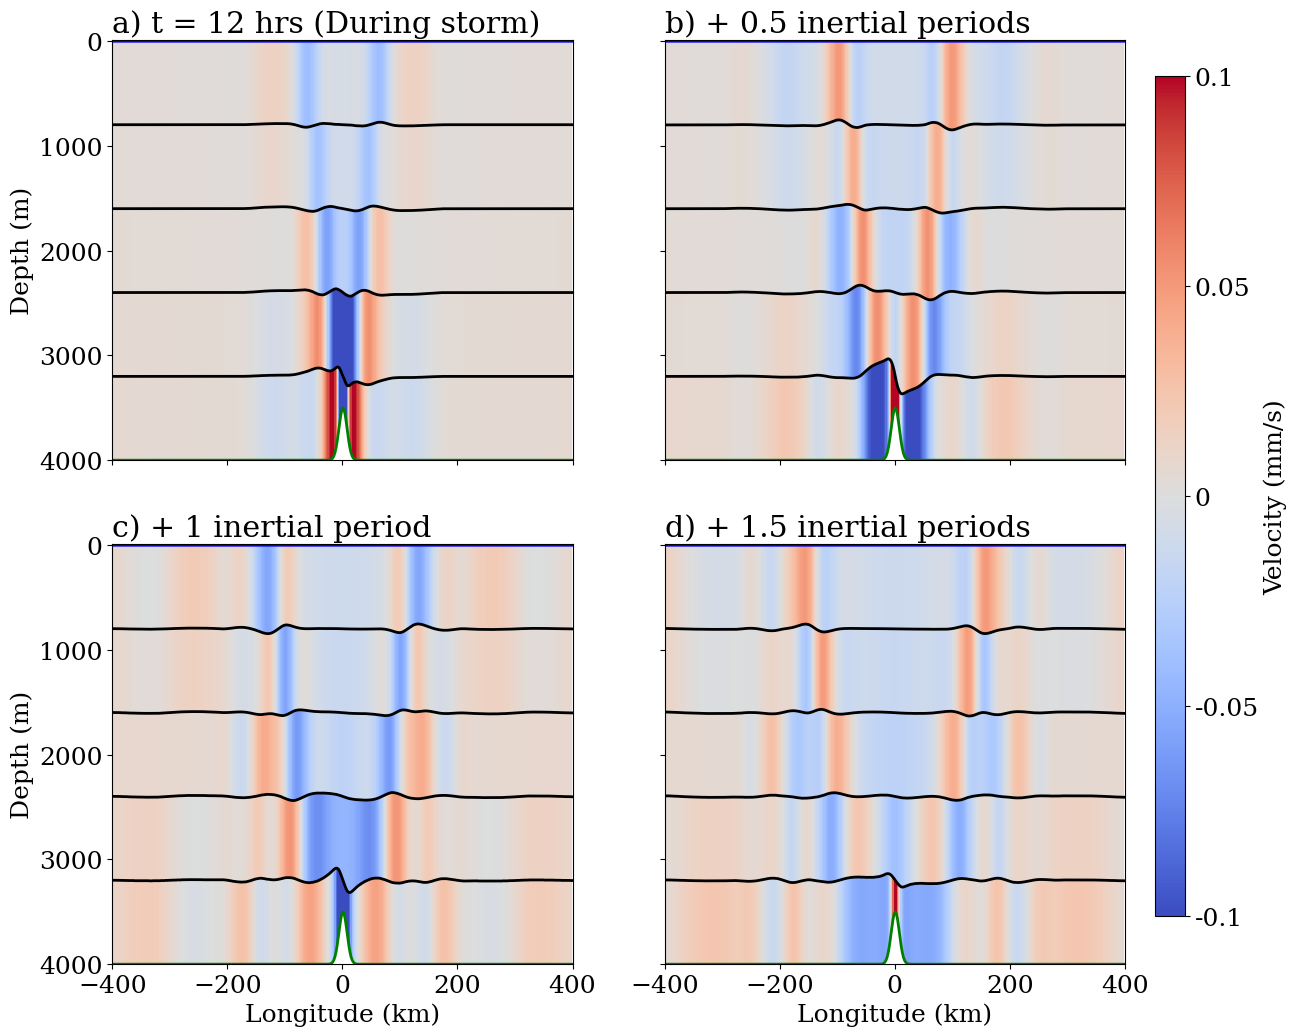

In [10]:
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
import seaborn as sns

# cmap = sns.color_palette("coolwarm", as_cmap=True,sep = 50)


def snapshot(time,ax):
    tt = time
    
    
    vmax = data_u.isel(time = tt).max().values * 0.1
    vmax = 0.0001
    vmin = -1 * vmax
    scaling = 3000 # Scale the anomaly in interface height
    x = data_u.xh
    mean_depths = data_e.isel(time = 0)
    base = mean_depths.isel(zi = 0)
    deviation = (data_e.isel(time = tt).isel(zi = 0) - mean_depths[0,tt])
    layer = base + deviation * scaling
    layer.plot(ax = ax,color = "blue",linewidth = 2)
    # for i in range(data_e.zi.shape[0] - 1):
    for i in range(0,4):
        prev_layer = layer
        
        ## Plot this layer 
        base = mean_depths.isel(zi = i+1)
        deviation = (data_e.isel(time = tt).isel(zi = i+1) - mean_depths.isel(zi = i+1))
        layer = base + deviation * scaling
        layer.plot(ax = ax,color = "black",linewidth = 2)
    
    
        # Create patch for the clipping of velocity field to fill space between layers. See https://matplotlib.org/stable/tutorials/advanced/path_tutorial.html
        
        verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer)], 1)]) ## creates vertices 
        path = Path(verts)
        patch = PathPatch(path, lw = 2,transform=ax.transData) ## patch to clip the velocity field
    
        # Plot velocity field and apply patch as clip path
        velfield = data_u.isel(time = tt,zl = i).expand_dims({"vert":2},axis = 1)
        extent=[x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],prev_layer.min().values.reshape(1)[0],layer.max().values.reshape(1)[0]]
        X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],x.shape[0]),np.linspace(prev_layer.min().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
        im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
        im.set_clip_path(patch)
    
    
    
    ## Handle bottom layer case
    prev_layer = layer
    layer = data_e.isel(time = 0,zi = -1)
    
    layer.plot(ax = ax,color = "green",linewidth = 2)
    
    verts = np.vstack([np.stack([x, layer], 1), np.stack([np.flip(x), np.flip(prev_layer)], 1)])
    path = Path(verts)
    
    patch = PathPatch(path, lw = 2,transform=ax.transData)
    
    # Plot bottom layer velocity
    velfield = data_u.isel(time = tt,zl = -1).expand_dims({"vert":2},axis = 1) 
    extent=[x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],prev_layer.min().values.reshape(1)[0],layer.max().values.reshape(1)[0]]
    X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],data_u.xh.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
    im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
    im.set_clip_path(patch)
    ax = plt.gca()
    ax.set_ylim([-4000,10])
    # ax.get_yaxis().ylim((-4000,0))
    
    # ax.set_yticks([])
    # ax.set_xticks([])
    # # canvas.invert_yaxis()
    # # canvas.set_title("Unfiltered, middle of channel slice")
    # add colorbar with caption
    # fig.colorbar(im, ax=ax, label='Horinzontal velocity (m/s)')

    
    return ax
    

fig,axes = plt.subplots(2,2,figsize = (15,12),sharey = True,sharex=True)


start = 80

## Get inertial period
fp = (2 * np.pi / 0.0001) / 3600
print(fp)
fp_10mins = fp * 6

captions = ["a) t = 12 hrs (During storm)","b) + 0.5 inertial periods","c) + 1 inertial period","d) + 1.5 inertial periods"]

# for i,time in enumerate([30,60,120,180]):
for i,time in enumerate([start,start + round(fp_10mins * 0.5),start + round(fp_10mins * 1),start + round(fp_10mins * 1.5)]):
    print(i)
    snapshot(time,axes[i//2,i%2])
    axes[i//2,i%2].set_title("")

    axes[i//2,i%2].set_title(captions[i],loc = "left")


    axes[i//2,i%2].set_xlabel("Longitude (km)")
    axes[i//2,i%2].set_ylabel("Depth (m)")
    axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])
    axes[i//2,i%2].set_yticks([-4000,-3000,-2000,-1000,0])
    if i%2 != 0:
        axes[i//2,i%2].set_ylabel("")
    if i//2 != 1:
        axes[i//2,i%2].set_xlabel("")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = matplotlib.colors.Normalize(vmin=-1e-1, vmax=1e-1)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="coolwarm"),cax = cbar_ax,label = f"Velocity (mm/s)")
cbar.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar.set_ticklabels([-0.1,-0.05,0,0.05,0.1])


